# <font color='#4C5FDA'>**Breast Cancer Detection Based on CNNs Using Thermal Imaging** </font>

Original paper by Juan Pablo Zuluaga, Zeina Al Masry, Khaled Benaggoune, Safa Meraghni & Noureddine Zerhouni: [A CNN-based methodology for breast cancer diagnosis using thermal images](https://www.tandfonline.com/doi/full/10.1080/21681163.2020.1824685)

In [1]:
#@title **Importamos librerías necesarias**

# PyTorch torchvision
from torchvision.transforms import v2

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, ConcatDataset

# Data manipulation
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
# from PIL import Image

## <font color='#ECA702'>**Configuración inicial para conectarnos con Kaggle**</font>

1. Instalamos kaggle. Para poder usar comandos de Kaggle.

In [2]:
! pip install kaggle

Subimos nuestro token de autenticación de Kaggle (si estamos en colab, sino colocarlo en la carpeta del proyecto)

In [ ]:
from google.colab import files
files.upload()

1. Creamos los directorios de Kaggle
2. Copiamos nuestro token en .kaggle
3. Con `chmod 600` establecemos los permitos del token en 600, es decir, que solo yo tengo permisos de lectura y escritura sobre el archivo

In [3]:
! mkdir ~/kaggle

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## <font color='#ECA702'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Carga del dataset**</font>

Traemos el dataset [Thermal Images for Breast Cancer Diagnosis DMR-IR](https://www.kaggle.com/datasets/asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir) desde kaggle.

This dataset is a methodology for breast disease computer-aided diagnosis using dynamic thermography. The thermal images for breast tumors are classified according to DMR-IR standards.

Two types of tumors are classified in this dataset one is benign another is malignant.
- Benign: This type of tumor is usually well-defined and round or oval in shape. (non-cancerous tumor)
- Malignant: This type of tumor is usually poorly defined and irregular with lobules. (cancerous tumor)

In [ ]:
! kaggle datasets download -d asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir
! unzip thermal-images-for-breast-cancer-diagnosis-dmrir.zip

Después de descargar los datos. Debemos entender la estructura de las carpetas para poder trabajar con ellas de una mejor manera.
1. La carpeta principal `Imagens e Matrizes da Tese de Thiago Alves Elias da Silva` son todos los datos `data`.
2. La carpeta `12 Novos Casos de Testes` la podemos tomar como nuestro conjunto de prueba (`test`).
3. Mientras que la carpeta `Desenvolvimento da Metodologia` será nuestro conjunto de entrenamiento (`train`).

Luego dentro de nuestras carpetas de `train` y `test` encontramos dos categorías `DOENTES`y `SAUDAтХа├╝VEIS` o SAUDÁVEI. Los primeros son los casos malignos y los segundos benignos.

Dentro de cada una de las carpetas de pacientes saludables y enfermos se encuentran carpetas con números, cada número representa un paciente. Y para cada paciente tendremos dos carpetas más, una para las imágenes **segmentadas** en escala de grises y la otra para la matrix o mapa de calor.

Algo bueno de este dataset es que ya está dividido por pacientes, es decir, no tendremos imagenes del mismo paciente en el conjunto de entrenamiento y testeo. Por lo tanto, vamos a entrenar con N pacientes, y testear con K pacientes, que no son los mismos.

### <font color='#52F17F'>**Preprocesamiento de los datos**</font>

#### <font color="6600CC">**Ejemplo con un sample**</font>

In [4]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN0.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
36.22 21.07


In [5]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN1.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
35.98 21.05


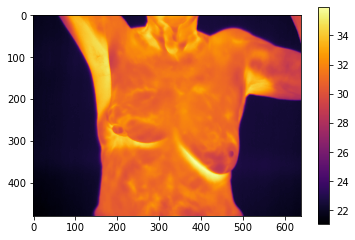

In [6]:
plt.imshow(matrix, cmap="inferno")
plt.colorbar()
plt.show()

In [7]:
img_gray = cv2.imread("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png", cv2.IMREAD_GRAYSCALE)
print(img_gray.shape, img_gray.dtype, img_gray.min(), img_gray.max())

(480, 640) uint8 0 222


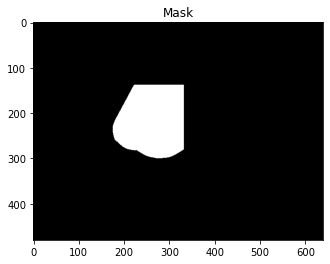

In [8]:
segmented = np.where(img_gray==0, 0, 1)
plt.imshow(segmented, cmap='gray')
plt.title('Mask')
plt.show()

In [9]:
segmented = matrix * segmented
print(segmented.shape, segmented.dtype, segmented.min(), segmented.max())

(480, 640) float64 0.0 34.400001525878906


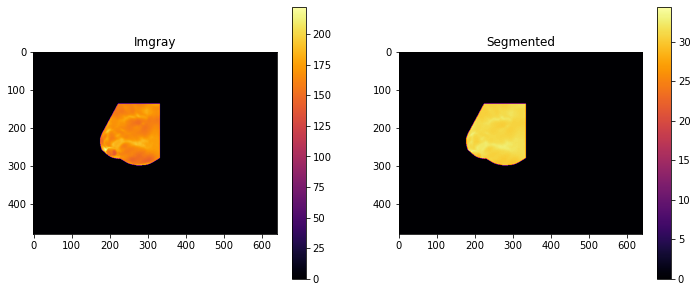

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Imgray")
plt.imshow(img_gray, cmap="inferno")
plt.colorbar()
plt.subplot(122)
plt.title("Segmented")
plt.imshow(segmented, cmap="inferno")
plt.colorbar()
plt.show()

#### <font color="6600CC">**Haciendo el cropp**</font>

In [102]:
def crop_breast(img):
  img_copy = img.copy().astype('uint8')

  # Crear un binario invertido de la imagen
  _, thresh = cv2.threshold(img_copy, 10, 255, cv2.THRESH_BINARY)

  # Encontrar contornos
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Si no se encuentran contornos, retornar la imagen original
  if not contours:
      return img
  
  # Encontrar el rectángulo delimitador que contiene el objeto
  largest_contour = max(contours, key=cv2.contourArea)
  x, y, w, h = cv2.boundingRect(largest_contour)

  # Recortar la imagen utilizando el rectángulo delimitador
  cropped_image = img[y:y+h, x:x+w]
  if cropped_image.shape[0] < 10 or cropped_image.shape[1] < 10:
    return img

  # Hago resize (para que todas las imagenes tengan el mismo tamaño)
  cropped_image = cv2.resize(cropped_image, (250, 300))

  return cropped_image

In [103]:
img_cropped = crop_breast(segmented)
print(img_cropped.dtype, img_cropped.shape, img_cropped.max(), img_cropped.min())
print(segmented.shape, segmented.dtype, segmented.max(), segmented.min())

float64 (300, 250) 34.22382633209228 0.0
(480, 640) float64 34.400001525878906 0.0


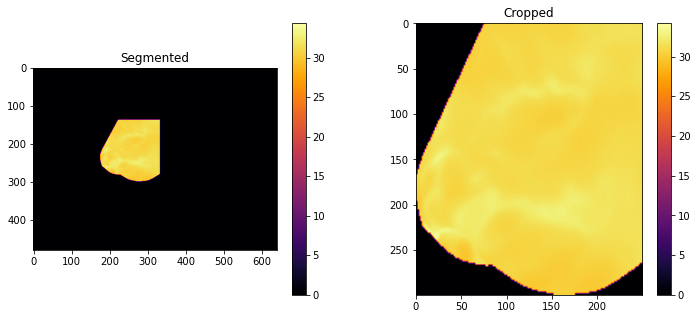

In [104]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Segmented")
plt.imshow(segmented, cmap="inferno")
plt.colorbar()
plt.subplot(122)
plt.title("Cropped")
plt.imshow(img_cropped, cmap="inferno")
plt.colorbar()
plt.show()

¿Qué pasa si le hago resize? ¿Qué tamaño conviene? https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05

In [97]:
img_cropped_resized = cv2.resize(img_cropped, (112, 112))
print(img_cropped_resized.dtype, img_cropped_resized.shape, img_cropped_resized.max(), img_cropped_resized.min())

float64 (112, 112) 33.773650732756685 0.0


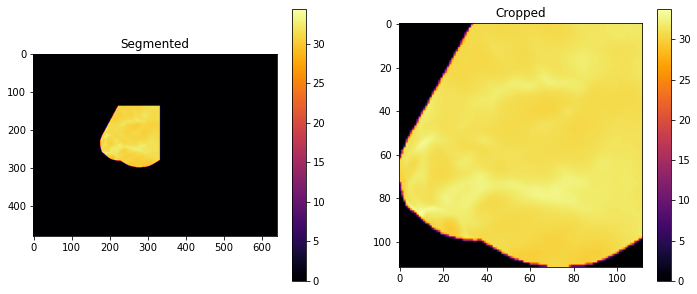

In [98]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Segmented")
plt.imshow(segmented, cmap="inferno")
plt.colorbar()
plt.subplot(122)
plt.title("Cropped")
plt.imshow(img_cropped_resized, cmap="inferno")
plt.colorbar()
plt.show()

#### <font color="6600CC">**Detalle con las imágenes segmentadas**</font>

In [31]:
# La primera la lee en RGB, pero la original viene con 4 canales
img_der = cv2.imread("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png")

# # https://stackoverflow.com/questions/3803888/how-to-load-png-images-with-4-channels
img_original = cv2.imread("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png", cv2.IMREAD_UNCHANGED)

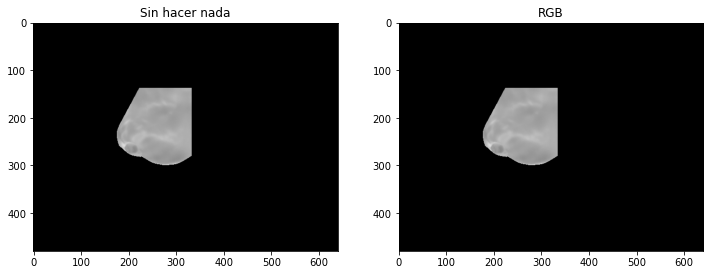

In [32]:
plt.figure(figsize=(12,9))
plt.subplot(121)
plt.title("Sin hacer nada")
plt.imshow(img_original)
plt.subplot(122)
plt.title("RGB")
plt.imshow(img_der)
plt.show()

¿Por qué las segmentadas vienen en 4 canales? ¿Cómo interpretar el cuarto canal?

In [33]:
img_original[:, :, 3]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

¿Qué es?: https://youtu.be/jF43_wj_DCQ?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN&t=53

In [383]:
"""
Constante encontrada al iterar por todas las imágenes segmentadas, 
calcular su valor máximo de temperatura y devolver el máximo de todas.
"""

MAX_TEMPERATURE = 36.44

In [384]:
class ThermalDataset(Dataset):
  def __init__(self, image_dir: str, matrix_dir: str, transform = None, normalize = None, crop:bool = None):
    self.image_dir = image_dir
    self.matrix_dir = matrix_dir
    self.transform = transform
    self.normalize = normalize
    self.crop = crop
    self.images = os.listdir(image_dir) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos la imagen de la lista
    img_path = os.path.join(self.image_dir, self.images[index])

    # Leemos la imagen segmentada en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # uint8
    # img = Image.open(img_path)


    """ Carga de la matrix """

    # Entramos a la carpeta y conseguimos la matrix de la lista.
      # La razon por la que uso la misma lista de imagenes es porque la imagen y la matrix
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ matrizes: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN0.txt """
    """ segmentada: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png """
    
    if '-dir.png' in self.images[index]:
      matrix_path = os.path.join(self.matrix_dir, self.images[index].replace("-dir.png", ".txt"))
    elif '-esq.png' in self.images[index]:
      matrix_path = os.path.join(self.matrix_dir, self.images[index].replace("-esq.png", ".txt"))
      
    matrix = np.loadtxt(matrix_path, dtype=np.float32) # https://www.geeksforgeeks.org/import-text-files-into-numpy-arrays/

    """ Consigo la imagen segmentada con los valores de la matrix """

    segmented = np.where(img==0, 0, 1) # int64
    # segmented = img * matrix
    img_segmented = (matrix * segmented).astype(np.float32) # float32, shape (480, 640)

    if self.crop:
      img_crop = crop_breast(img_segmented) 

    # Le agrego un canal explícito 
    img_crop = np.expand_dims(img_crop, axis=2) # https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html

    if self.normalize:
      img = img / MAX_TEMPERATURE

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'DOENTES' 1
    # sino 0.

    label = self.image_dir.split('/')[2]
    if label == 'DOENTES':
      label = 1
    else:
      label = 0

    """ Convertir las imagenes en tensores y hacer resize """
    if self.transform:
      # Aplicamos las transformaciones a la imagen
      # print(type(img), img.shape)
      img_crop = self.transform(img_crop)
      
    return img, matrix, segmented, img_segmented, img_crop, label

In [385]:
TEST_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes"
TRAIN_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"

In [386]:
# Primero consigo la ruta de imagenes y matrices para cada uno de los pacientes

dirs_test = []
test_images = 0
test_matrices = 0
for category in os.listdir(TEST_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TEST_PATH, category)):
    # print(os.path.join(TEST_PATH, category, patient))
    dirs_test.append(os.path.join(TEST_PATH, category, patient))
    _, _, files = next(os.walk(os.path.join(TEST_PATH, category, patient, "Segmentadas")))
    # print(files)
    test_images += len(files)
    _, _, files = next(os.walk(os.path.join(TEST_PATH, category, patient, "Matrizes")))
    test_matrices += len(files)


dirs_train = []
train_images = 0
train_matrices = 0
for category in os.listdir(TRAIN_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TRAIN_PATH, category)):
    # print(os.path.join(TRAIN_PATH, category, patient))
    dirs_train.append(os.path.join(TRAIN_PATH, category, patient))
    _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Segmentadas")))
    train_images += len(files)
    try:
      _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Matrizes")))
      train_matrices += len(files)
    except:
      _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Matrizes de Temperatura")))
      train_matrices += len(files)



# Imprimo la cantidad de pacientes y datos que tenemos
print(f"Cantidad de pacientes para testeo: {len(dirs_test)}")
print(f"Cantidad de imagenes para testeo: {test_images}")
print(f"Cantidad de matrices para testeo: {test_matrices}")
print()
print(f"Cantidad de pacientes para entrenamiento: {len(dirs_train)}")
print(f"Cantidad de imagenes para entrenamiento: {train_images}")
print(f"Cantidad de matrices para entrenamiento: {train_matrices}")

Cantidad de pacientes para testeo: 9
Cantidad de imagenes para testeo: 240
Cantidad de matrices para testeo: 180

Cantidad de pacientes para entrenamiento: 47
Cantidad de imagenes para entrenamiento: 1282
Cantidad de matrices para entrenamiento: 948


En teoría por cada paciente tenemos 20 imagenes, pero las cuentas no cuadran, por ejemplo en testeo deberíamos tener 9x20 = 180 imagenes, pero aparecen 240. Esto sucede debido a que hay algunas imagenes que están separadas en la parte izquierda y derecha.

Para el conjunto de entrenamiento tampoco cuadra el número de matrices. Esto es debido a que algunos pacientes tienen una matriz que se llama `ESTATICO` que no tengo ni idea para qué es pero no es problema ya que no hace 'match' con ninguna imágen.

In [387]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES/245/Matrizes/PAC_26_ESTATICO.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
35.02 20.38


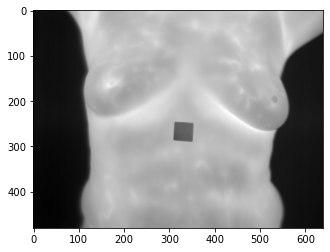

In [388]:
plt.imshow(matrix, cmap='gray')
plt.show()

In [389]:
# Todas las imagenes vienen en h: 480, w: 640. El objetivo es disminuir el tamaño
# sin perder la relación de aspecto. https://gist.github.com/tomvon/ae288482869b495201a0

HEIGHT = 250
r = HEIGHT/480 # Calculo la relación de aspecto. 
WIDTH = int(640*r)
# print(f"Las imagenes son reescaladas a {HEIGHT}x{WIDTH}")

# https://pytorch.org/vision/main/transforms.html#performance-considerations
transform = v2.Compose([  
    v2.ToImage(), 
    # v2.Resize(size=(HEIGHT, WIDTH), antialias=True), 
])

Para cada paciente armo un dataset y luego con `ConcatDataset` junto todos los pacientes para entrenamiento y para testeo.

In [390]:
test_datasets = []
for patient in dirs_test:
  folders = sorted(os.listdir(patient))
  # print(folders)
  test_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=transform, crop=True))

In [391]:
train_datasets = []
for patient in dirs_train:
  folders = sorted(os.listdir(patient))
  # print(folders)
  train_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=transform, crop=True))

In [392]:
# Datasets (concatenate) https://stackoverflow.com/questions/60840500/pytorch-concatenating-datasets-before-using-dataloader
test_dataset = ConcatDataset(test_datasets)
train_dataset = ConcatDataset(train_datasets)
full_dataset = ConcatDataset([test_dataset, train_dataset])

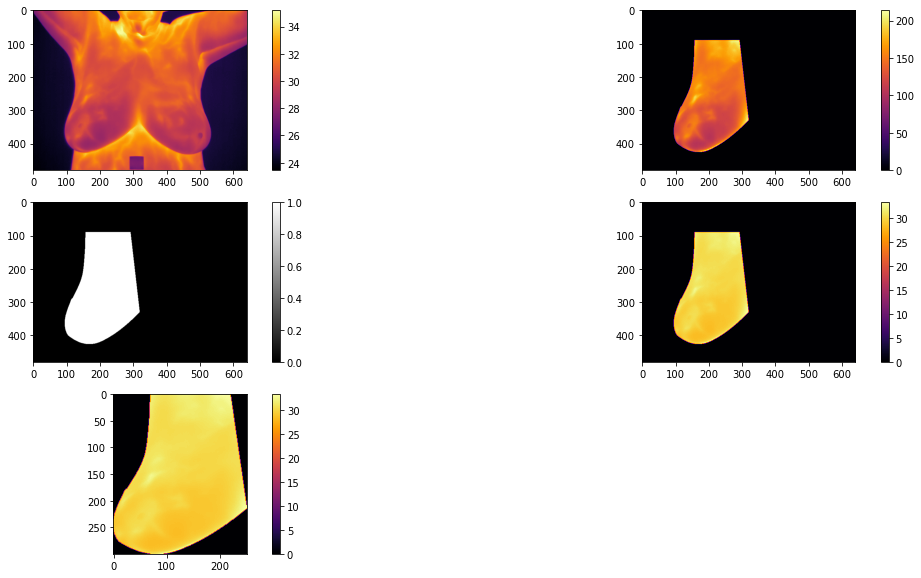

In [393]:
idx = 1070
plt.figure(figsize=(20,10))
plt.subplot(321)
plt.imshow(full_dataset[idx][1], cmap='inferno')
plt.colorbar()
plt.subplot(322)
plt.imshow(full_dataset[idx][0], cmap='inferno')
plt.colorbar()
plt.subplot(323)
plt.imshow(full_dataset[idx][2], cmap='gray')
plt.colorbar()
plt.subplot(324)
plt.imshow(full_dataset[idx][3], cmap='inferno')
plt.colorbar()
plt.subplot(325)
plt.imshow(full_dataset[idx][4].squeeze(0), cmap='inferno')
plt.colorbar()
plt.show()

#### <font color="6600CC">**Consiguiendo la temperatura máxima de todas las imágenes segmentadas**</font>

In [394]:
MAX_TEMPERATURE = 0
for record in full_dataset:
  max_temperature_record = record[4].squeeze(0).numpy().max()
  # print(max_temperature_record)
  if max_temperature_record > MAX_TEMPERATURE:
    MAX_TEMPERATURE = max_temperature_record
    print(MAX_TEMPERATURE)

31.937202
33.052982
33.192825


libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


33.315662


libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


33.89668
33.913883
34.307167
35.042274
35.209293
35.299034
35.450573
35.85312
36.155067
36.425987


In [395]:
print(MAX_TEMPERATURE)

36.425987


### <font color='#52F17F'>**Visualización de datos**</font>

In [396]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(20, rows * 4))
    breast_types = {0: 'Benign', 1: 'Malignant'}

    np.random.seed(2024)

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        img = dataset[idx][0] # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][5] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
        # plt.savefig('preprocess_gray')
    plt.show()

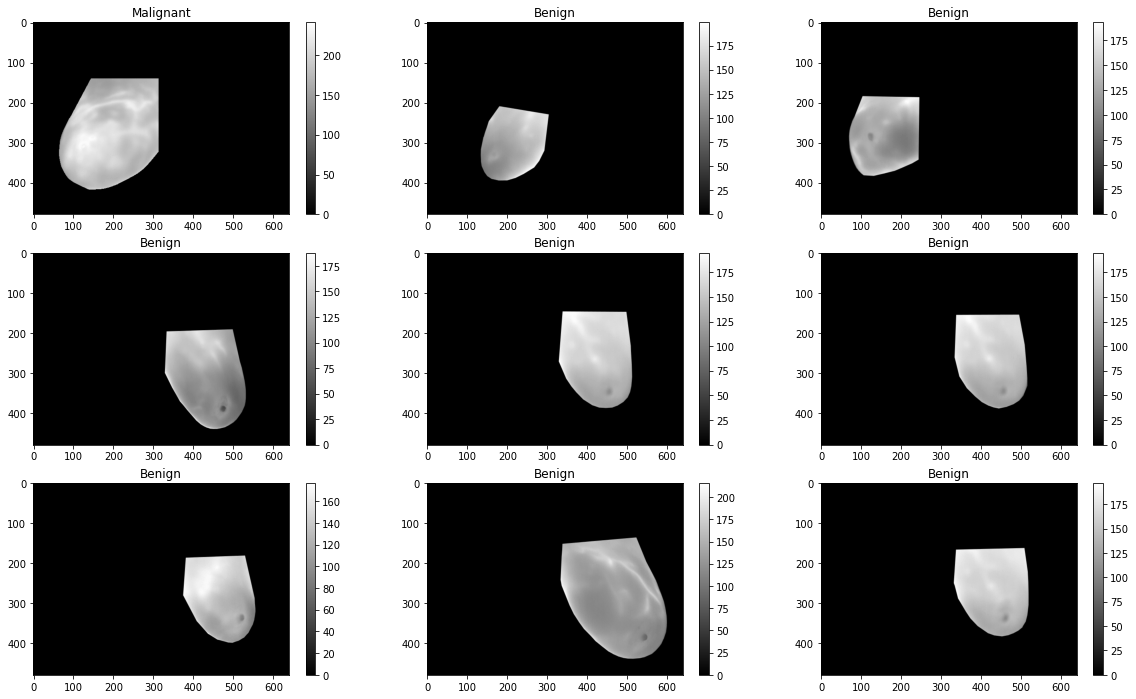

In [397]:
visualize_data(train_dataset)

In [398]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(20, rows * 4))
    breast_types = {0: 'Benign', 1: 'Malignant'}

    np.random.seed(2024)

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        # img = dataset[idx][1].squeeze(0) # Extraer la imagen y eliminar dimensiones singleton si es necesario
        img = dataset[idx][1] # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][5] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='inferno')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
        # plt.savefig('preprocess')
    plt.show()

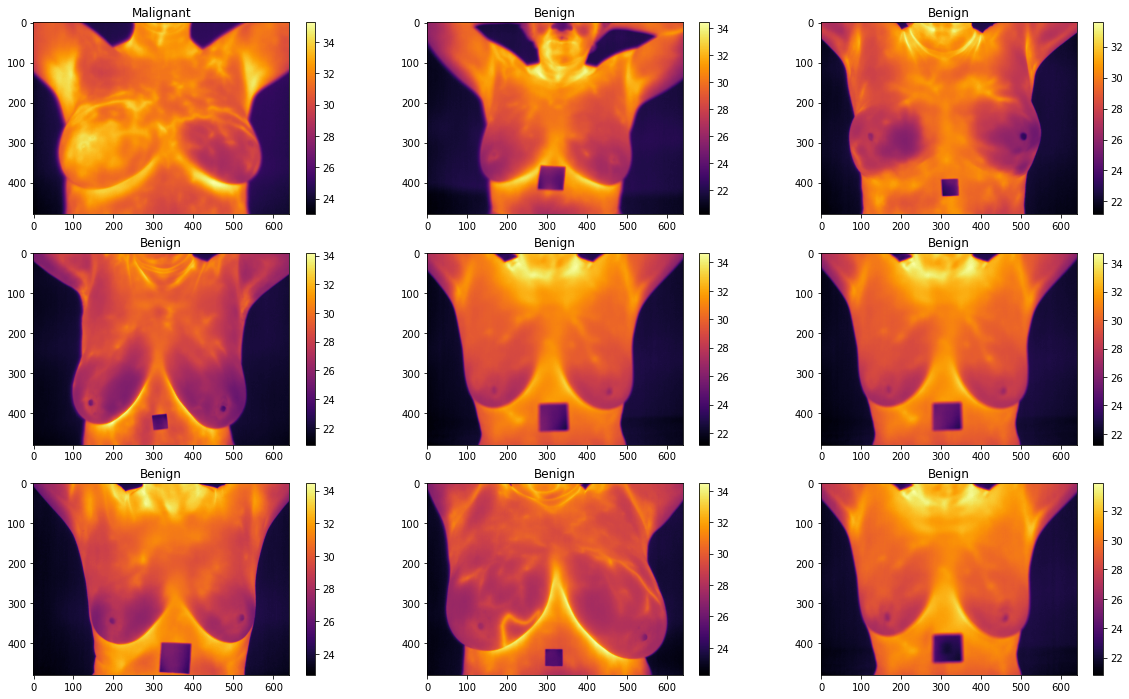

In [399]:
visualize_data(train_dataset)

In [400]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(20, rows * 4))
    breast_types = {0: 'Benign', 1: 'Malignant'}

    np.random.seed(2024)

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        # img = dataset[idx][1].squeeze(0) # Extraer la imagen y eliminar dimensiones singleton si es necesario
        img = dataset[idx][2] # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][5] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='gray')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
        # plt.savefig('preprocess_mask')
    plt.show()

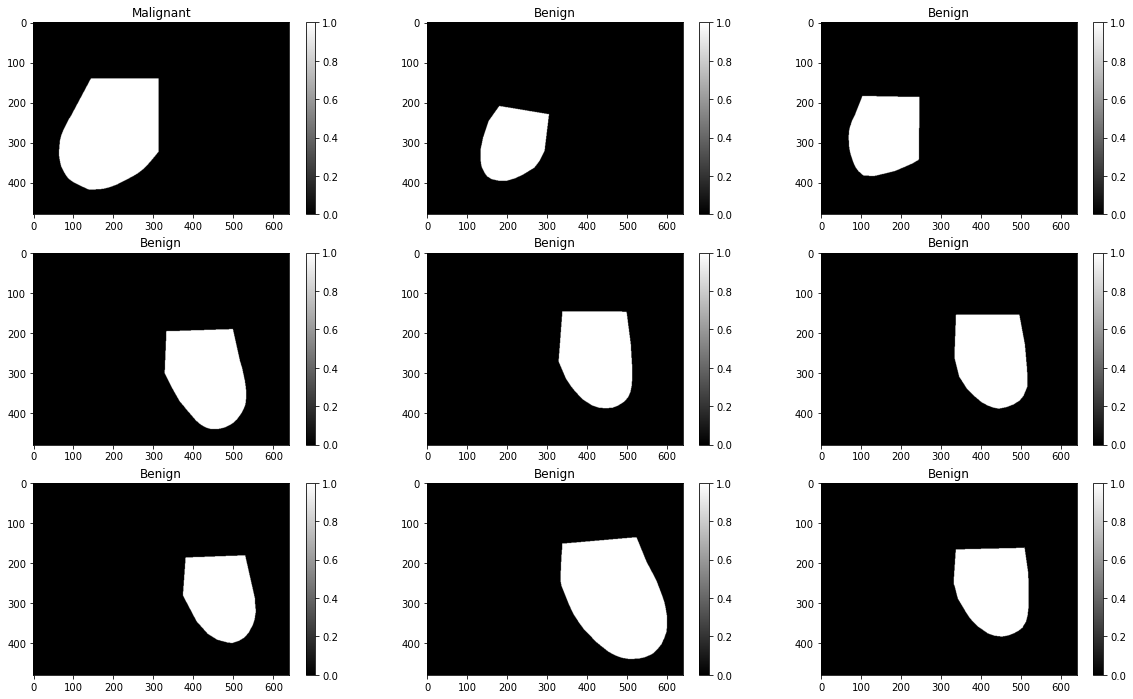

In [401]:
visualize_data(train_dataset)

In [402]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(20, rows * 4))
    breast_types = {0: 'Benign', 1: 'Malignant'}

    np.random.seed(2024)

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        img = dataset[idx][3] # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][5] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='inferno')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
        # plt.savefig('preprocess_segmented')
    plt.show()

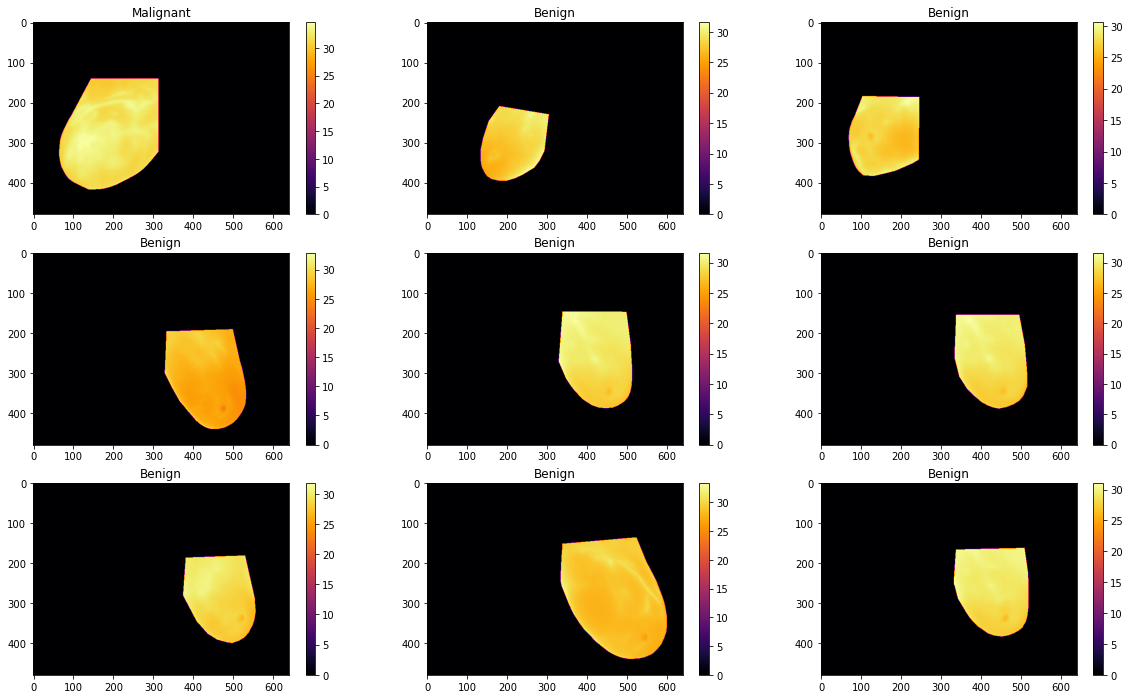

In [403]:
visualize_data(train_dataset)

In [404]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(20, rows * 4))
    breast_types = {0: 'Benign', 1: 'Malignant'}

    np.random.seed(2024)

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        img = dataset[idx][4].squeeze(0) # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][5] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='inferno')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
        plt.savefig('preprocess_cropped')
    plt.show()

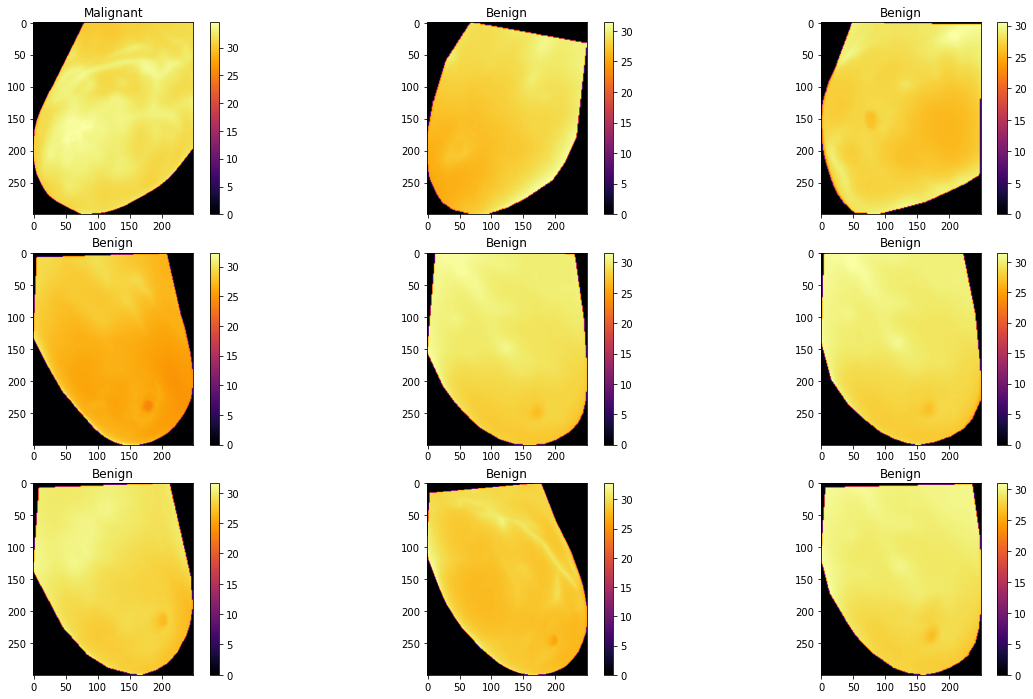

In [405]:
visualize_data(train_dataset)

### <font color='#52F17F'>**Aumento de datos**</font>

In [406]:
transformations = [
    ("RandomHorizontalFlip", v2.RandomHorizontalFlip(p=1)),
    ("RandomVerticalFlip", v2.RandomVerticalFlip(p=1)),
    ("RandomRotation degrees=45", v2.RandomRotation(degrees=45)),
    ("GaussianBlur k=5", v2.RandomApply([v2.GaussianBlur(kernel_size=5)], p=1)),
    ("RandomAffine 5%", v2.RandomApply([v2.RandomAffine(degrees=0, translate=(0.05, 0.05))], p=1))
]

In [407]:
def visualize_transformations(dataset, transformations, rows=3, cols=3):
    """
    Visualiza las imágenes con las transformaciones aplicadas individualmente.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        transformations (list): Lista de tuplas con el nombre y la transformación a aplicar.
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(20, rows * 4))
    np.random.seed(2024)

    # Seleccionar un índice aleatorio del dataset
    idx = np.random.choice(len(dataset))
    original_img = dataset[idx][4] # Extraer la imagen original y eliminar dimensiones singleton si es necesario

    # Mostrar la imagen original
    plt.subplot(rows, cols, 1)
    plt.imshow(original_img.squeeze(0), cmap='inferno')
    plt.title("Original")
    plt.colorbar()

    # Aplicar y mostrar cada transformación
    for i, (name, transform) in enumerate(transformations, start=2):
        transformed_img = transform(original_img)
        plt.subplot(rows, cols, i)
        plt.imshow(transformed_img.squeeze(0), cmap='inferno')
        plt.title(name)
        plt.colorbar()

    plt.savefig('preprocess_augmented')
    plt.show()

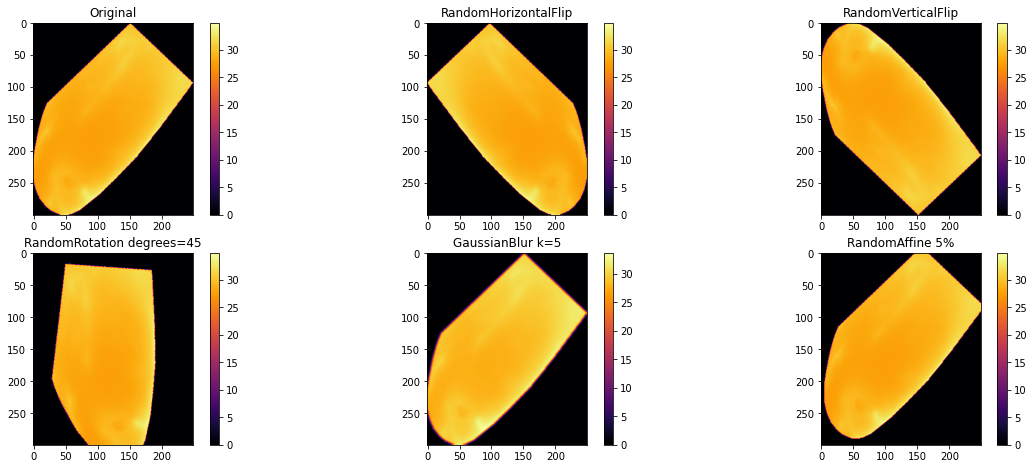

In [408]:
visualize_transformations(train_dataset, transformations)

### <font color='#52F17F'>**Verificando el crop**</font>

In [409]:
from torch.utils.data import DataLoader

# Crear un DataLoader
data_loader = DataLoader(full_dataset, batch_size=10, shuffle=False)

# Visualizar las imágenes
def visualize_images(data_loader, num_images=20):
    images = []
    for batch in data_loader:
        for _, _, _, _, img_cropped, _ in zip(*batch):
            images.append(img_cropped)
            if len(images) >= num_images:
                break
        if len(images) >= num_images:
            break

    num_cols = 5
    num_rows = (num_images // num_cols) + (1 if num_images % num_cols != 0 else 0)

    plt.figure(figsize=(15, num_rows * 3))
    for i, img in enumerate(images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img.squeeze(0), cmap='inferno')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


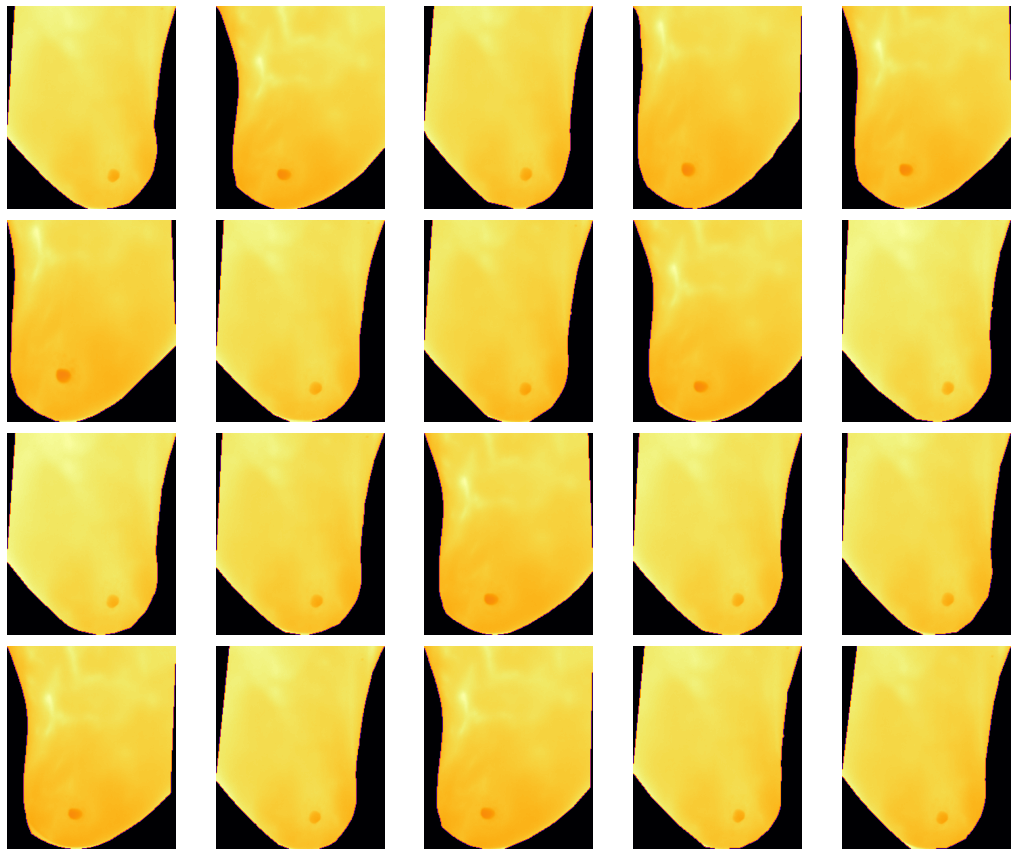

In [410]:
# Visualizar las imágenes recortadas
visualize_images(data_loader, num_images=20)

In [411]:
def save_cropped_images(data_loader, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    count = 0
    for batch in data_loader:
        for _, _, _, _, img_cropped, _ in zip(*batch):
            save_path = os.path.join(output_dir, f'cropped_img_{count}.png')
            plt.imsave(save_path, img_cropped.squeeze(0), cmap='gray')
            count += 1

In [412]:
output_dir = 'cropped_images'
save_cropped_images(data_loader, output_dir)

libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
